# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


%matplotlib inline

# Utility functions

from pytorch tutorial

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Import data

In [3]:
train_transforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize from tutorial

val_test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #normalize from tutorial

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=val_test_transforms)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=val_test_transforms)

baseset_size = trainset.__len__()
testset_size = testset.__len__()

print("Training set size is {}".format(baseset_size))
print("Testing set size is {}".format(testset_size))

item = trainset.__getitem__(0)
print(classes[item[1]])
#imshow(item[0])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size is 50000
Testing set size is 10000
frog


# Constants

training / testing constants 


performs train/val split


data batcher

In [11]:
train_percent = 0.7
batch_size = 128
batch_size_predict = 256
num_workers = 10
num_classes = 10
pin_memory = True

num_epochs = 60
learning_rate = 0.001
optomizers = ('SGD', 'Adam')
myOptomizer = optomizers[1]
networks = ('exampleNet', 'FC2_2', 'VGGshallow', 'VGGshallow_1FC', 'VGGshallow_3FC', 'VGGshallow_3FC_deep')
currentNetwork = networks[0]
initializer = ('random', 'Xavier')
initialization = initializer[1]
batchNormalization = True

useGPU = True
if useGPU:
    dtype = torch.cuda.FloatTensor
    dtype2 = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor
    dtype2 = torch.LongTensor
    
#torch.cudnn.benchmark = True

#-----------------------------------------------------------------
#data batching
#-----------------------------------------------------------------


train_num = int(train_percent*baseset_size)
val_num = int(train_percent*(1-baseset_size))

index = list(range(baseset_size))
random.shuffle(index)

train_ind = index[:train_num]
val_ind = index[train_num:]

print(len(index))

print("Training set is {} long".format(len(train_ind)))
print("Validation set is {} long".format(len(val_ind)))

train_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

train_loader = torch.utils.data.DataLoader(trainset, 
                batch_size=batch_size, sampler=train_sampler, 
                num_workers=num_workers, pin_memory=pin_memory, drop_last = True)

val_loader = torch.utils.data.DataLoader(valset, 
                batch_size=batch_size_predict, sampler=val_sampler, 
                num_workers=num_workers, pin_memory=pin_memory, drop_last = True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_predict,
                                         shuffle=False, num_workers=2, drop_last = True)


50000
Training set is 35000 long
Validation set is 15000 long


print(batch_size)
dataiter = iter(test_loader)
print(dataiter.next()[0])

# Networks

Net_tutorial is from the pytorch tutorial, it doesn't do very well.

In [12]:
#basenet from pytorch tutorial
class Net_tutorial(nn.Module):
    def __init__(self, initialization):
        super(Net_tutorial, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        
        if initialization == 'Xavier':
            nn.init.xavier_uniform(self.conv1.weight)
            nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x

#deeper basenet
class FC2_2(nn.Module):
    def __init__(self, initialization):
        super(FC2_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 6, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(6, 16, 3, 1)
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 16, 3, 1)
        self.conv4_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        
        if initialization == 'Xavier':
            nn.init.xavier_uniform(self.conv1.weight)
            nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = (F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = (F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x
    
#vgg style net using 3x3 convs and 2x2 max pools    
class VGGshallow(nn.Module):
    def __init__(self):
        super(VGGshallow, self).__init__()
        self.architecture = [64, 64, 'P', 128, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'P']
        self.layers = []
        
        input_channels = 3
        for layer in self.architecture:
            output_channels = layer
            if layer == 'P':
                self.layers.append(nn.MaxPool2d(2,2))
                
            else:
                self.layers.append(nn.Conv2d(input_channels, output_channels, 3, 1, 1))
                self.layers.append(nn.BatchNorm2d(output_channels))
                self.layers.append(nn.ReLU(inplace=True))    
                input_channels = output_channels
        
        self.conv_layers = nn.Sequential(*self.layers)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)
        
        #if initialization == 'Xavier':
        #    nn.init.xavier_uniform(self.conv1.weight)
        #    nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
class VGGshallow_1FC(nn.Module):
    def __init__(self):
        super(VGGshallow_1FC, self).__init__()
        self.architecture = [64, 64, 'P', 128, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'P']
        self.layers = []
        
        input_channels = 3
        for layer in self.architecture:
            output_channels = layer
            if layer == 'P':
                self.layers.append(nn.MaxPool2d(2,2))
                
            else:
                self.layers.append(nn.Conv2d(input_channels, output_channels, 3, 1, 1))
                self.layers.append(nn.BatchNorm2d(output_channels))
                self.layers.append(nn.ReLU(inplace=True))    
                input_channels = output_channels
        
        self.conv_layers = nn.Sequential(*self.layers)
        self.fc2 = nn.Linear(512, 10)
        
        #if initialization == 'Xavier':
        #    nn.init.xavier_uniform(self.conv1.weight)
        #    nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x
    
class VGGshallow_3FC(nn.Module):
    def __init__(self):
        super(VGGshallow_3FC, self).__init__()
        self.architecture = [64, 64, 'P', 128, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'P']
        self.layers = []
        
        input_channels = 3
        for layer in self.architecture:
            output_channels = layer
            if layer == 'P':
                self.layers.append(nn.MaxPool2d(2,2))
                
            else:
                self.layers.append(nn.Conv2d(input_channels, output_channels, 3, 1, 1))
                self.layers.append(nn.BatchNorm2d(output_channels))
                self.layers.append(nn.ReLU(inplace=True))    
                input_channels = output_channels
        
        self.conv_layers = nn.Sequential(*self.layers)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        #if initialization == 'Xavier':
        #    nn.init.xavier_uniform(self.conv1.weight)
        #    nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
class VGGshallow_3FC_deep(nn.Module):
    def __init__(self):
        super(VGGshallow_3FC_deep, self).__init__()
        self.architecture = [64, 64, 'P', 128, 128, 'P', 256, 256, 'P', 512, 512, 'P', 1024, 1024, 'P']
        self.layers = []
        
        input_channels = 3
        for layer in self.architecture:
            output_channels = layer
            if layer == 'P':
                self.layers.append(nn.MaxPool2d(2,2))
                
            else:
                self.layers.append(nn.Conv2d(input_channels, output_channels, 3, 1, 1))
                self.layers.append(nn.BatchNorm2d(output_channels))
                self.layers.append(nn.ReLU(inplace=True))    
                input_channels = output_channels
        
        self.conv_layers = nn.Sequential(*self.layers)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        
        #if initialization == 'Xavier':
        #    nn.init.xavier_uniform(self.conv1.weight)
        #    nn.init.xavier_uniform(self.conv2.weight)


    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    

if currentNetwork == 'exampleNet':
    net = Net_tutorial(initialization = initialization)

if currentNetwork == 'FC2_2':
    net = FC2_2(initialization = initialization)
    
if currentNetwork == 'VGGshallow':
    net = VGGshallow()

if currentNetwork == 'VGGshallow_1FC':
    net = VGGshallow_1FC()    

if currentNetwork == 'VGGshallow_3FC':
    net = VGGshallow_3FC()
    
if currentNetwork == 'VGGshallow_3FC_deep':
    net = VGGshallow_3FC_deep() 

if useGPU:
    net = net.cuda() #moves to gpu
    #net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count())) #just added, might not work
    cudnn.benchmark = True
    
print(currentNetwork)

exampleNet


In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
if myOptomizer == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50], gamma=0.1)

else:
    if myOptomizer == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)


'''
Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
'''

'\nArgs:\n        params (iterable): iterable of parameters to optimize or dicts defining\n            parameter groups\n        lr (float): learning rate\n        momentum (float, optional): momentum factor (default: 0)\n        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)\n        dampening (float, optional): dampening for momentum (default: 0)\n        nesterov (bool, optional): enables Nesterov momentum (default: False)\n'

Note:
torch variable is wrapper which of tensor + gradient
torch tensor is an array / matrix

In [14]:
def predict(net, data_loader, num_class, batch_size):
    correct = 0#torch.Tensor(num_class).zero_()

    #print(labels.numpy().shape)
    for data in data_loader:
            inputs, labels = data
            inputs = Variable(inputs.type(dtype))
            output = net(inputs)
            _, predicted = torch.max(output.data, 1) #finds max index
            correct = (predicted.cpu().numpy() == labels.numpy()).squeeze() #labels is max index, not one-hot


    accuracy = np.average(correct)
    #print(accuracy)
    #print(num_class)
    return correct, num_class, accuracy

#correct, num_class, accuracy = predict(net, data_loader, num_class, batch_size)
#print(accuracy)


def predict(net, data_loader, num_class, batch_size):
    correct = 0#torch.Tensor(num_class).zero_()

    #print(labels.numpy().shape)
    for data in data_loader:
            inputs, labels = data
            inputs = Variable(inputs.type(dtype))
            output = net(inputs)
            _, predicted = torch.max(output.data, 1) #finds max index
            correct = (predicted.cpu().numpy() == labels.numpy()).squeeze() #labels is max index, not one-hot


    accuracy = np.average(correct)
    #print(accuracy)
    #print(num_class)
    return correct, num_class, accuracy

#correct, num_class, accuracy = predict(net, data_loader, num_class, batch_size)
#print(accuracy)

In [15]:
print(net)

Net_tutorial(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear(in_features=400, out_features=120)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear(in_features=120, out_features=84)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear(in_features=84, out_features=10)
)


In [16]:
acc_epochs = torch.Tensor(3, num_epochs).zero_()

for epoch in tqdm(range(num_epochs)):  #epoch is full dataset, tqdm does progress bar
    epoch_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        # grab a batch
        inputs, labels = data

        #convert to cuda w/ gradient
        inputs = Variable(inputs.type(dtype))
        labels = Variable(labels.type(dtype2))
        
        #reset gradient for epoch
        optimizer.zero_grad()

        #forward/backward/update
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.data[0]
        
    #record train, validation, test accuracy:
    _, _, acc_epochs[0][epoch] = predict(net, train_loader, num_classes, batch_size)
    _, _, acc_epochs[1][epoch] = predict(net, val_loader, num_classes, batch_size_predict)
    _, _, acc_epochs[2][epoch] = predict(net, test_loader, num_classes, batch_size_predict)
    
    tqdm.write("Epoch loss = {}".format(epoch_loss / i))
    scheduler.step()

print('Finished Training')

  2%|▏         | 1/60 [00:04<04:09,  4.23s/it]

Epoch loss = 1.760991571142393


  3%|▎         | 2/60 [00:08<04:05,  4.23s/it]

Epoch loss = 1.4752736753400635


  5%|▌         | 3/60 [00:12<04:02,  4.25s/it]

Epoch loss = 1.3606978567207562


  7%|▋         | 4/60 [00:17<03:59,  4.28s/it]

Epoch loss = 1.2910230860990637


  8%|▊         | 5/60 [00:21<03:54,  4.26s/it]

Epoch loss = 1.2494999247000498


 10%|█         | 6/60 [00:25<03:50,  4.26s/it]

Epoch loss = 1.2020255469662302


 12%|█▏        | 7/60 [00:29<03:45,  4.26s/it]

Epoch loss = 1.187469944357872


 13%|█▎        | 8/60 [00:34<03:41,  4.26s/it]

Epoch loss = 1.1580117820378613


 15%|█▌        | 9/60 [00:38<03:37,  4.27s/it]

Epoch loss = 1.134742252090398


 17%|█▋        | 10/60 [00:42<03:33,  4.27s/it]

Epoch loss = 1.1185871564290102


 18%|█▊        | 11/60 [00:47<03:29,  4.27s/it]

Epoch loss = 1.095918648164062


 20%|██        | 12/60 [00:51<03:25,  4.27s/it]

Epoch loss = 1.080763760735007


 22%|██▏       | 13/60 [00:55<03:20,  4.27s/it]

Epoch loss = 1.070441917023238


 23%|██▎       | 14/60 [00:59<03:16,  4.27s/it]

Epoch loss = 1.055075649610337


 25%|██▌       | 15/60 [01:04<03:12,  4.27s/it]

Epoch loss = 1.0414496651467156


 27%|██▋       | 16/60 [01:08<03:08,  4.27s/it]

Epoch loss = 1.03316271896748


 28%|██▊       | 17/60 [01:12<03:03,  4.27s/it]

Epoch loss = 1.0251600952709423


 30%|███       | 18/60 [01:16<02:59,  4.27s/it]

Epoch loss = 1.019072222578175


 32%|███▏      | 19/60 [01:21<02:55,  4.28s/it]

Epoch loss = 0.9966460729346556


 33%|███▎      | 20/60 [01:25<02:50,  4.27s/it]

Epoch loss = 0.995239385348909


 35%|███▌      | 21/60 [01:29<02:46,  4.27s/it]

Epoch loss = 0.9985879105241859


 37%|███▋      | 22/60 [01:33<02:42,  4.27s/it]

Epoch loss = 0.9811902861384785


 38%|███▊      | 23/60 [01:38<02:37,  4.27s/it]

Epoch loss = 0.9744991513297838


 40%|████      | 24/60 [01:42<02:33,  4.27s/it]

Epoch loss = 0.9643838504219756


 42%|████▏     | 25/60 [01:46<02:29,  4.27s/it]

Epoch loss = 0.9570253997602883


 43%|████▎     | 26/60 [01:50<02:25,  4.27s/it]

Epoch loss = 0.9548074077157414


 45%|████▌     | 27/60 [01:55<02:20,  4.27s/it]

Epoch loss = 0.9540012888610363


 47%|████▋     | 28/60 [01:59<02:16,  4.26s/it]

Epoch loss = 0.9442425931201262


 48%|████▊     | 29/60 [02:03<02:12,  4.27s/it]

Epoch loss = 0.9317203538821024


 50%|█████     | 30/60 [02:07<02:07,  4.27s/it]

Epoch loss = 0.9386054134982473


 52%|█████▏    | 31/60 [02:12<02:03,  4.27s/it]

Epoch loss = 0.9259549326756421


 53%|█████▎    | 32/60 [02:16<01:59,  4.27s/it]

Epoch loss = 0.9273008379866096


 55%|█████▌    | 33/60 [02:20<01:55,  4.26s/it]

Epoch loss = 0.9204420655527535


 57%|█████▋    | 34/60 [02:24<01:50,  4.26s/it]

Epoch loss = 0.9148063883185387


 58%|█████▊    | 35/60 [02:29<01:46,  4.26s/it]

Epoch loss = 0.9202275409856263


 60%|██████    | 36/60 [02:33<01:42,  4.26s/it]

Epoch loss = 0.9097995328552583


 62%|██████▏   | 37/60 [02:37<01:38,  4.26s/it]

Epoch loss = 0.9082751666360042


 63%|██████▎   | 38/60 [02:41<01:33,  4.26s/it]

Epoch loss = 0.9062298762009424


 65%|██████▌   | 39/60 [02:46<01:29,  4.26s/it]

Epoch loss = 0.8969038477277055


 67%|██████▋   | 40/60 [02:50<01:25,  4.26s/it]

Epoch loss = 0.9003815241158009


 68%|██████▊   | 41/60 [02:54<01:20,  4.26s/it]

Epoch loss = 0.8923243821105536


 70%|███████   | 42/60 [02:58<01:16,  4.26s/it]

Epoch loss = 0.8889233079903266


 72%|███████▏  | 43/60 [03:03<01:12,  4.26s/it]

Epoch loss = 0.8918709768091931


 73%|███████▎  | 44/60 [03:07<01:08,  4.26s/it]

Epoch loss = 0.8849323378766284


 75%|███████▌  | 45/60 [03:11<01:03,  4.25s/it]

Epoch loss = 0.8784921701778384


 77%|███████▋  | 46/60 [03:15<00:59,  4.25s/it]

Epoch loss = 0.8793053646736285


 78%|███████▊  | 47/60 [03:19<00:55,  4.25s/it]

Epoch loss = 0.8776830375632819


 80%|████████  | 48/60 [03:24<00:51,  4.25s/it]

Epoch loss = 0.8705094134544625


 82%|████████▏ | 49/60 [03:28<00:46,  4.25s/it]

Epoch loss = 0.874261870761128


 83%|████████▎ | 50/60 [03:32<00:42,  4.25s/it]

Epoch loss = 0.8622106664321002


 85%|████████▌ | 51/60 [03:36<00:38,  4.25s/it]

Epoch loss = 0.8580557554960251


 87%|████████▋ | 52/60 [03:41<00:34,  4.25s/it]

Epoch loss = 0.8593839396010426


 88%|████████▊ | 53/60 [03:45<00:29,  4.25s/it]

Epoch loss = 0.8631643532391857


 90%|█████████ | 54/60 [03:49<00:25,  4.25s/it]

Epoch loss = 0.8496732575928464


 92%|█████████▏| 55/60 [03:53<00:21,  4.25s/it]

Epoch loss = 0.854906418305986


 93%|█████████▎| 56/60 [03:58<00:17,  4.25s/it]

Epoch loss = 0.8512868651134127


 95%|█████████▌| 57/60 [04:02<00:12,  4.25s/it]

Epoch loss = 0.8491620995542583


 97%|█████████▋| 58/60 [04:06<00:08,  4.25s/it]

Epoch loss = 0.844440477735856


 98%|█████████▊| 59/60 [04:10<00:04,  4.25s/it]

Epoch loss = 0.8449112678713658


100%|██████████| 60/60 [04:14<00:00,  4.25s/it]

Epoch loss = 0.8426812326206881
Finished Training


0.765625, 0.6796875, 0.671875
0.671875


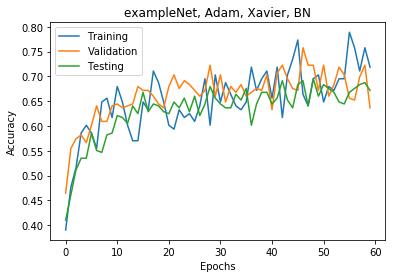

In [18]:
_, _, TRAIN = predict(net, train_loader, num_classes, batch_size)
_, _, VAL = predict(net, val_loader, num_classes, batch_size_predict)
_, _, TEST = predict(net, test_loader, num_classes, batch_size_predict)

print("{}, {}, {}".format(TRAIN, VAL, TEST))


plt.plot(acc_epochs[0].numpy())
plt.plot(acc_epochs[1].numpy())
plt.plot(acc_epochs[2].numpy())
plt.legend(['Training', 'Validation', 'Testing'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

string = 'no BN'
if batchNormalization:
    string = 'BN'
plt.title('{}, {}, {}, {}'.format(currentNetwork, myOptomizer, initialization, string))

print(acc_epochs[2].numpy()[-1])


# Nice plotting example

from PyTorch tutorial

GroundTruth:    cat  ship  ship plane


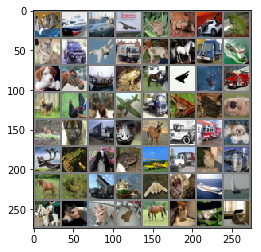

In [30]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))